# Project Description

In this project, we are going to use Python to extract news articles titles, from www.financiarul.ro, www.zf.ro and www.digi24.ro, label them as positive, neutral or negative (sentiment), and finally train and deploy a Machine Learning algorithm (Naive Bayes) that can label any given title, with a certain accuracy and precision score. The language used will be Romanian.

# Extracting Titles

We are going to use the BeautifulSoup module for Python, in order to extract the titles from the .xml sitemap.

In [1]:
from bs4 import BeautifulSoup
import requests

feed_url = 'https://financiarul.ro/sitemap-news.xml'
r = requests.get(feed_url)
xml = r.text

soup = BeautifulSoup(xml,features="xml")

titles = soup.select('title')

#Create list of strings containing all the extracted titles
#and remove the <news:title> tags

titles_list = []
start = '>'
end = '<'
index = 0
for index in range(len(titles)):
    s = str(titles[index])
    s = s[s.find(start)+len(start):s.rfind(end)]
    titles_list.append(s)

In [2]:
titles_list

['OpenAI, finanțare de miliarde. La ce valoare a ajuns gigantul',
 'Românii care au intrat în vizorul ANAF. Se confiscă totul',
 'Apare un nou sistem de plăți în România. BNR a dat undă verde',
 'Casa verde fotovoltaice. Milioane de lei rezervate pentru biserici',
 'Ucraina, interzis la export. Ce produse nu mai intră în România',
 'Aeroportul Otopeni va avea un nou terminal. Ciolacu: Va fi perla Europei',
 '5 beneficii ale ambalajelor de unică folosință biodegradabile și compostabile pentru restaurante și cafenele',
 'De ce să oferi coșuri cadou partenerilor de afaceri: Impactul pe termen lung',
 '3 recomandări de design interior pentru birouri și spații de lucru',
 'Alpiniștii utilitari și siguranța la înălțime: Cum ne asigurăm că serviciile sunt realizate fără riscuri',
 'Cea mai sănătoasă cafea din lume. Costă foarte puțin',
 'Prețurile locuințelor și chiriilor au crescut în UE. Cu cât s-au majorat în România',
 'Restricții de circulație în București. Se închid multe străzi',
 'Cel

In [3]:
len(titles_list)

54

Before we can start labelling, we should collect more titles from other news websites, since 54 is not enough. The aim should be around 500 titles. Then the labelling process can start.

Let us look at www.zf.ro "Ziarul Financiar", and try to find its xml sitemap.
It is on https://www.zf.ro/sitemap.xml . Now we shall extract the titles from the sitemap.

In [4]:
from bs4 import BeautifulSoup
import requests

feed_url = 'https://www.zf.ro/sitemap.xml'
r = requests.get(feed_url)
xml = r.text

soup = BeautifulSoup(xml,features="xml")

titles = soup.select('title')

In [5]:
titles[0]

<news:title>Ionuţ Ciprian Dejeu, Distri Fresh International: Am încercat să depunem foarte multe proiecte pe fonduri europene în ultima perioadă, chiar ne-am angajat în firmă un specialist, dar din păcate condiţiile sunt tot mai stricte</news:title>

In [6]:
start = '>'
end = '<'
index = 0
for index in range(len(titles)):
    s = str(titles[index])
    s = s[s.find(start)+len(start):s.rfind(end)]
    titles_list.append(s)

In [7]:
titles_list[54]

'Ionuţ Ciprian Dejeu, Distri Fresh International: Am încercat să depunem foarte multe proiecte pe fonduri europene în ultima perioadă, chiar ne-am angajat în firmă un specialist, dar din păcate condiţiile sunt tot mai stricte'

In [8]:
len(titles_list)

179

Good! One more website and we should be good to go!

In [9]:
from bs4 import BeautifulSoup
import requests

feed_url = 'https://www.digi24.ro/stiri/economie'
r = requests.get(feed_url)
xml = r.text

soup = BeautifulSoup(xml,features="html.parser")

titles = soup.find_all(class_='article-title')

In [10]:
titles[0]

<h2 class="article-title"> <a href="/stiri/externe/mapamond/ue-ar-putea-muri-avertismentul-dur-al-presedintelui-francez-emmanuel-macron-2955397" title="„UE ar putea muri”. Avertismentul dur al președintelui francez Emmanuel Macron. Pe ce se contrazice cu cancelarul Olaf Scholz"> „UE ar putea muri”. Avertismentul dur al președintelui francez Emmanuel Macron. Pe ce se contrazice cu cancelarul Olaf Scholz </a> </h2>

In [11]:
start = 'title="'
end = '"> '
index = 0
for index in range(len(titles)):
    s = str(titles[index])
    s = s[s.find(start)+len(start):s.rfind(end)]
    titles_list.append(s)

In [13]:
titles_list[179]

'„UE ar putea muri”. Avertismentul dur al președintelui francez Emmanuel Macron. Pe ce se contrazice cu cancelarul Olaf Scholz'

In [14]:
len(titles_list)

229

Let us repeat the same process we did for the digi24.ro website, for multiple pages, by placing the previous code in a for loop.

In [15]:
for page_number in [2,3,4,5,6]:
    
    page_number_string = str(page_number)
    feed_url = 'https://www.digi24.ro/stiri/economie?p=' + page_number_string
    r = requests.get(feed_url)
    xml = r.text

    soup = BeautifulSoup(xml,features="html.parser")

    titles = soup.find_all(class_='article-title')

    start = 'title="'
    end = '"> '
    index = 0
    for index in range(len(titles)):
        s = str(titles[index])
        s = s[s.find(start)+len(start):s.rfind(end)]
        titles_list.append(s)

In [16]:
len(titles_list)

479

Unfortunately, some of the titles look like the following. We need to remove the end of these strings.

In [17]:
titles_list[393]

'„CNP-ul fiscal”, criticat de experți și comercianți: „Evazioniștii nu vor avea nicio problemă”"> <span class="title-tag'

In [31]:
title_index = 0
end = '"> <span class="title-tag'

for title_index in range(len(titles_list)):
        titles_list[title_index] = titles_list[title_index].removesuffix('"> <span class="title-tag')

In [32]:
titles_list[393]

'„CNP-ul fiscal”, criticat de experți și comercianți: „Evazioniștii nu vor avea nicio problemă”'

# Labelling

Now we want to add the titles as rows in a .xlsx (Excel) file, because it can preserve the Romanian diacritics. One column will hold the titles, and the other column, the labels, as "positive","neutral" or "negative".

In [39]:
from pandas import DataFrame

Label = []
index = 0
for index in range(len(titles_list)):
    Label.append('')


df = DataFrame({'Title':titles_list,'Label':Label})

In [40]:
df.to_excel('titles.xlsx',index=False)

We can finally start the labelling process, in Excel.

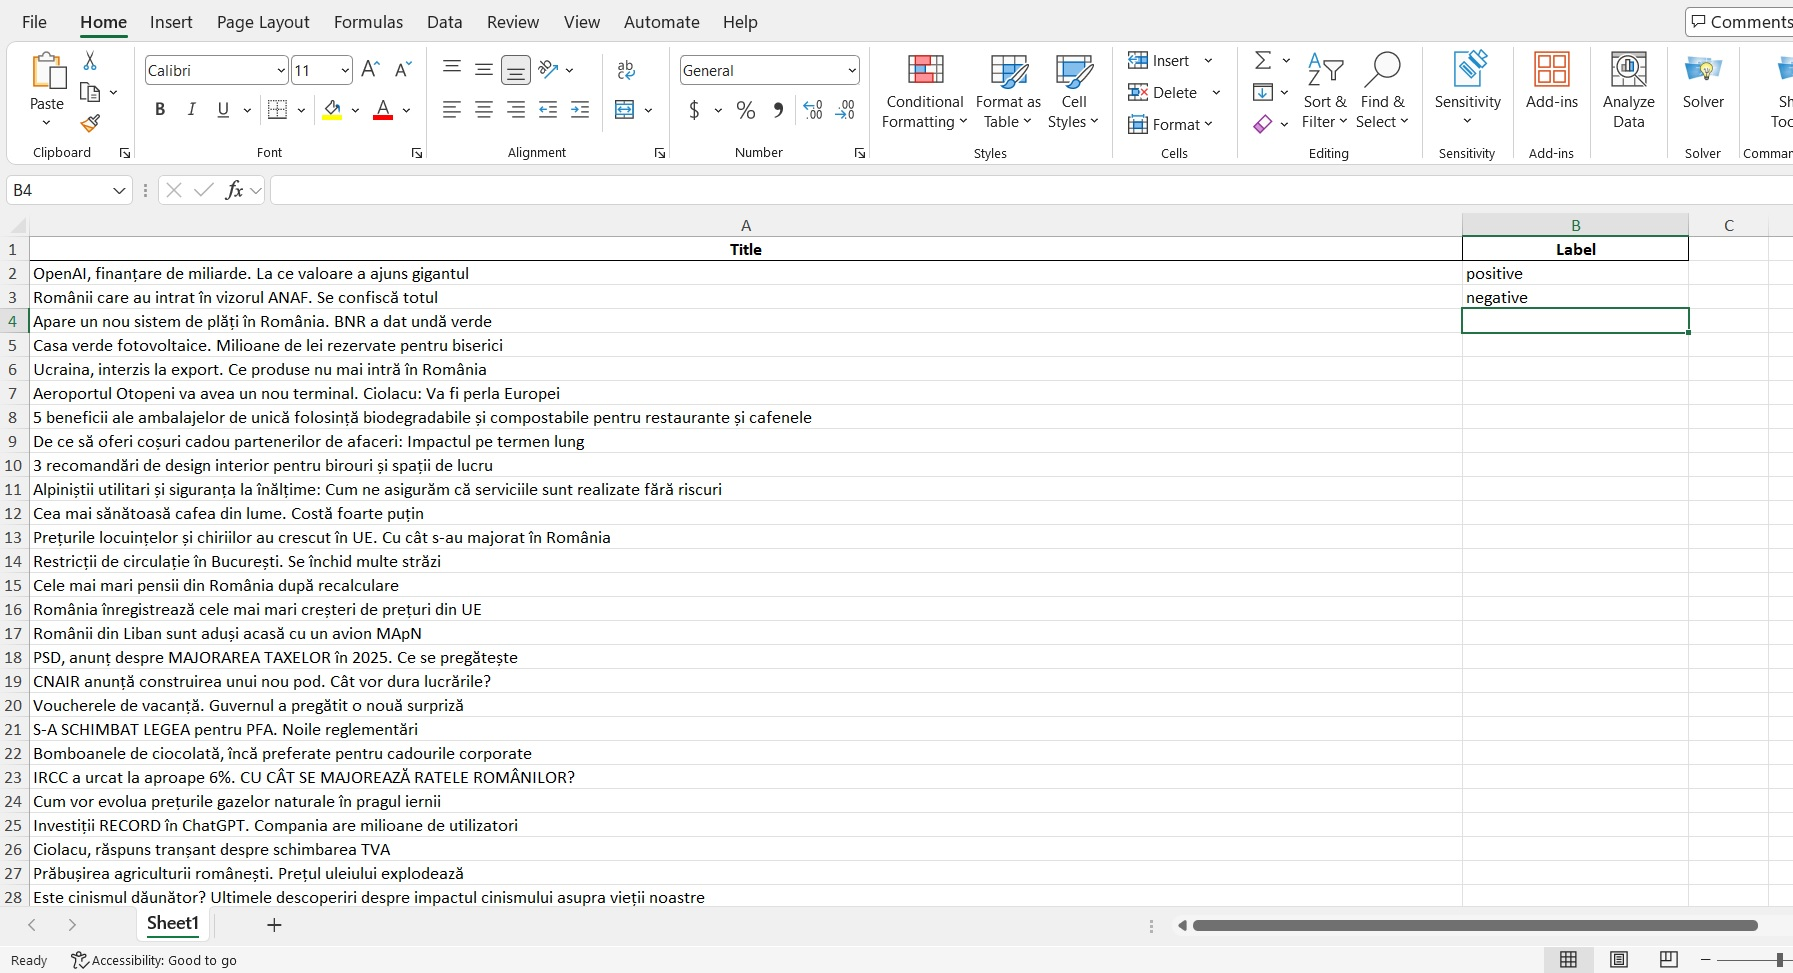

# Exploratory Data Analysis

We should check the balance of the three labels.

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("titles.xlsx")

In [3]:
df.head()

,Title,Label
0,"OpenAI, finanțare de miliarde. La ce valoare a...",positive
1,Românii care au intrat în vizorul ANAF. Se con...,negative
2,Apare un nou sistem de plăți în România. BNR a...,positive
3,Casa verde fotovoltaice. Milioane de lei rezer...,neutral
4,"Ucraina, interzis la export. Ce produse nu mai...",negative


In [4]:
df['Label'].value_counts()

Label
neutral     186
negative    176
positive    117
Name: count, dtype: int64

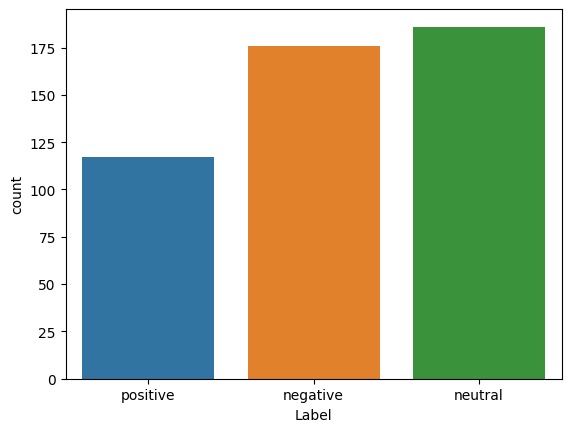

In [5]:
sns.countplot(data=df,x='Label',hue='Label');

The data set is reasonably balanced, with the majority of the labels being neutral and negative. This might cause a slight bias.

# Features and Label

In [6]:
X = df['Title']
y = df['Label']

In [7]:
#Train/test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Model Training

In [8]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tfidf,y_train)

MultinomialNB()

# Performance Metrics

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report

predictions = nb.predict(X_test_tfidf)
print(classification_report(y_test,predictions,zero_division=0))

              precision    recall  f1-score   support

    negative       0.72      0.40      0.51        45
     neutral       0.37      0.87      0.51        30
    positive       0.00      0.00      0.00        21

    accuracy                           0.46        96
   macro avg       0.36      0.42      0.34        96
weighted avg       0.45      0.46      0.40        96



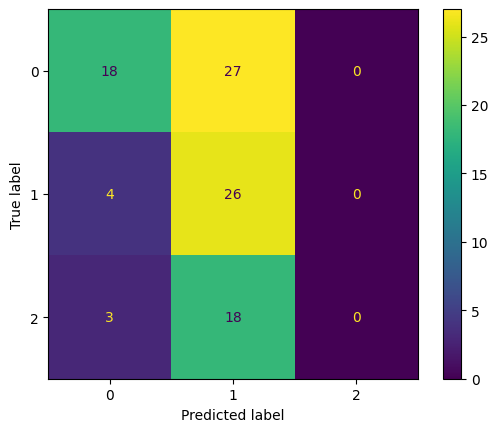

In [10]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

Unfortunately, the model is not performing well, as it does not predict the positive label at all. It seems it performs best at predicting the neutral label. We can try changing the fit_prior parameter inside the MultinomialNB object, which is True by default, to False. According to the documentation, this parameter affects "whether to learn class prior probabilities or not. If false, a uniform prior will be used.".

In [43]:
nb = MultinomialNB(fit_prior=False)
nb.fit(X_train_tfidf,y_train)
predictions = nb.predict(X_test_tfidf)
print(classification_report(y_test,predictions,zero_division=0))

              precision    recall  f1-score   support

    negative       0.67      0.58      0.62        45
     neutral       0.48      0.77      0.59        30
    positive       0.56      0.24      0.33        21

    accuracy                           0.56        96
   macro avg       0.57      0.53      0.51        96
weighted avg       0.58      0.56      0.55        96



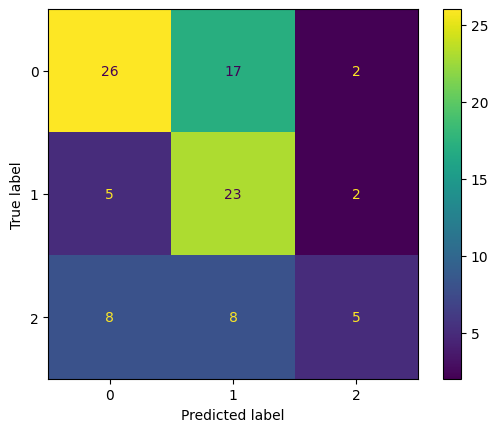

In [44]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [45]:
nb.class_count_

array([131., 156.,  96.])

We can finally fit on the entire data, and test on various examples.

In [14]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('tfidf',TfidfVectorizer()),('nb',MultinomialNB())])
pipe.fit(df['Title'],df['Label'])

example = ['PENSIONARI PĂCĂLIȚI. O pagubă de aproape un milion de lei pentru pensionari']
pipe.predict(example)

array(['negative'], dtype='<U8')

In [15]:
example = ['Câți români muncesc în țară. Cei mai mulți sunt în sectorul privat']
pipe.predict(example)

array(['neutral'], dtype='<U8')

In [16]:
example = ['Guvernul alocă bani suplimentari pentru fermieri. Ciolacu anunță noi fonduri și pentru autostrăzile Moldovei și Transilvaniei']
pipe.predict(example)


array(['positive'], dtype='<U8')